In [1]:
import sys, os
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../scripts')
root = os.getcwd()


from TwintDataMiner import TwintDataMiner
from PandasDataCleaner import PandasDataCleaner
from TextBlobSentiment import TextBlobSentiment
from Visualisation import Visualisation
from GMM import GMM


In [2]:
tweetsFile = "../data/final_location_tweets.csv"
tdm = TwintDataMiner()
attributes = ["id", "tweet", "place", "date"]
df = tdm.getPandasDataFrame(attributes, tweetsFile)
df.shape
df.head

<bound method NDFrame.head of                         id                                              tweet  \
0                       id                                              tweet   
1      1237392766671269900  Coronavirus outbreak and our precautions #posh...   
2      1237392766633512961  Estoy hablando con mi amigi sobre el #coronavi...   
3      1237392763848556549  How do you feel about #Coachella and #Stagecoa...   
4      1237392763508809730  o melhor remédio para o corona vírus é o corot...   
...                    ...                                                ...   
58335  1237166326449344513  The latest on the #Coronavirus in #SouthCaroli...   
58336  1237166322150256641  if you ever used the restrooms at 216,\nyou’re...   
58337  1237166316496322561  El primer enfermo de coronavirus apareció hace...   
58338  1237166283449393153  Además del Coronavirus siguen los infartos, lo...   
58339  1237166282543251456  #Trumpdemic trends nationwide as people vent a...  

In [3]:
df.drop_duplicates(subset='id')
df.shape

(58340, 4)

In [4]:
pdc = PandasDataCleaner()
def cleandf(df):
    df  = pdc.detectLanguage(df, 'tweet', 'lang')
    df = pdc.cleanTweets(df, 'tweet')
    df = df.loc[df['lang'] == 'en']
    df = df.reset_index(drop=True)
    return df

In [5]:
df = cleandf(df)

Detecting language: 58339/58340

In [6]:
saveddf = df.copy()

In [7]:
df = pdc.addGeneralLocation(df)

In [8]:
countDict = df.groupby('genplace').count()['id'].to_dict()
print(sorted( ((v,k) for k,v in countDict.items()), reverse=True))

[(3334, 'CA'), (3063, 'USA'), (1886, 'TX'), (1827, 'England'), (1673, 'NY'), (1312, 'FL'), (922, 'India'), (688, 'OH'), (647, 'IL'), (634, 'London'), (599, 'PA'), (527, 'MA'), (498, 'Ontario'), (491, 'NJ'), (470, 'GA'), (444, 'TN'), (435, 'AZ'), (429, 'Ireland'), (413, 'NC'), (387, 'MD'), (380, 'DC'), (379, 'VA'), (375, 'Nigeria'), (357, 'MI'), (356, 'WA'), (338, 'South Africa'), (331, 'LA'), (305, 'IN'), (296, 'Scotland'), (273, 'NV'), (261, 'CO'), (253, 'MO'), (216, 'AL'), (208, 'Victoria'), (194, 'OK'), (193, 'Spain'), (184, 'UT'), (180, 'MN'), (172, 'New South Wales'), (166, 'CT'), (165, 'SC'), (164, 'OR'), (163, 'WI'), (160, 'KY'), (149, 'Pakistan'), (146, 'Alberta'), (144, 'Ghana'), (143, 'KS'), (124, 'Brazil'), (123, 'IA'), (120, 'Northern Ireland'), (119, 'Wales'), (116, 'NE'), (115, 'France'), (113, 'Kenya'), (113, 'Argentina'), (110, 'National Capital Region'), (102, 'Germany'), (102, 'British Columbia'), (100, 'AR'), (98, 'Québec'), (95, 'MS'), (94, 'NM'), (80, 'Nederland'),

In [72]:
countries_to_model = ['USA', 'England', 'India', 'Ireland', 'Nigeria']#, 'South Africa', 'Scotland', 'Spain', 'Pakistan', 'Ghana', 'Brazil', 'Northern Ireland', 'Wales', 'France', 'Kenya', 'Argentina', 'Germany', 'Nederland', 'United Arab Emirates', 'Sri Lanka', 'Uganda', 'Indonesia', 'Türkiye', 'België', "People's Republic of China", 'Israel', 'Jamaica', 'Chile']

In [73]:
final_bow =['PPE',
 'afraid',
 'aggravation',
 'air',
 'alarmed',
 'alarming',
 'ante la crisis',
 'anxiety',
 'anxious',
 'apprehensive',
 'atmosphere',
 'brutal',
 'chaos',
 'chaotic',
 'charity',
 'clean air',
 'clean water',
 'comfort',
 'coronavirus fear',
 'crisis',
 'danger',
 'dangerous',
 'dead',
 'death',
 'disaster',
 'disastrous',
 'distress',
 'distressed',
 "don't panic",
 'donations',
 'earth',
 'encourage',
 'encouraging',
 'environment',
 'evil',
 'exaggerate',
 'exaggerating',
 'exaggeration',
 'faint',
 'fantastic',
 'fearful',
 'fearschaos',
 'fighter',
 'fitness',
 'flabbergast',
 'flabbergasted',
 'flatten',
 'food wastage',
 'freaked',
 'free',
 'fright',
 'frightened',
 'genocide',
 'gloves',
 'government funds',
 'gratitude',
 'grief',
 'grievance',
 'gruesome',
 'happy',
 'harm',
 'healing',
 'health issue',
 'heartbreaking',
 'hell',
 'helpless',
 'honor',
 'hope',
 'horrendous',
 'horrific',
 'horrify',
 'horrifying',
 'hospital',
 'humanity',
 'impovement',
 'improving',
 'kill',
 'killed',
 'killingthreat',
 'kills',
 'life-threatening',
 'masks',
 'meditation',
 'mild',
 'murder',
 'negative',
 'nervous',
 'not panic',
 'not serious',
 'nurses',
 'optimism',
 'optomistic',
 'overcome',
 'overreact',
 'overreacted',
 'overreacting',
 'ozone',
 'panic',
 'panick',
 'panicked',
 'panicking',
 'panicky',
 'paranoid',
 'pasta',
 'phobia',
 'positive',
 'problem',
 'progress',
 'promise',
 'promosing',
 'protect',
 'proud',
 'quality',
 'ran out',
 'rattle',
 'rattled',
 'recover',
 'recovery',
 'relief',
 'respect',
 'rice',
 'risk',
 'sad',
 'sadness',
 'scared',
 'scarefear',
 'scarier',
 'scariest',
 'scarily',
 'shock',
 'shocked',
 'shocking',
 'shockingly',
 'spanish flu',
 'strength',
 'strong',
 'stronger',
 'successfully',
 'support',
 'surreal',
 'terrible',
 'terror',
 'tests',
 'thank you',
 'thanks',
 'threatening',
 'together',
 'toilet paper',
 'tragic',
 'travel alert',
 'trust',
 'unbearable',
 'unhygienic',
 'unnerve',
 'unnerved',
 'unnerving',
 'unserious',
 'upset',
 'upseting',
 'upsets',
 'upsettingly',
 'vaccine',
 'warned'
 'warning',
 'wonderful',
 'worried',
 'worryingly',
 'worry',]

In [74]:
df = df.loc[df['genplace'].isin(countries_to_model)]
df = df.reset_index(drop=True)

In [75]:
df.head

<bound method NDFrame.head of                        id                                              tweet  \
0     1237392757691265028  Well, I give them some credit. They acknowledg...   
1     1237392659850780672  @ImtiazMadmood we knew corona virus back in 60...   
2     1237392327791874054   CORONAVIRUS, COVID 19  SARS-COV-2  Birth plac...   
3     1237392323094302720  A guy just sneezed at the back of my head. Ind...   
4     1237392298196914183               deadass think i have the coronavirus   
...                   ...                                                ...   
6611  1237166707921367042  At his age, #coronavirus would put him in ICU....   
6612  1237166699457261569  @SkyNews just heard the most irresponsible thi...   
6613  1237166473367498752  White kid don't think he can get the coronavir...   
6614  1237166439053828096  SO TIRED of hearing about the coronavirus. You...   
6615  1237166326449344513  The latest on the #Coronavirus in #SouthCaroli...   

         

In [76]:
country_bows = dict()
gmm = GMM()
def returncountry(place, country):
    if(country in place):
        return True
    return False
for country in countries_to_model:
    tempdf = df[df['genplace'].apply(lambda x: returncountry(x, country))].copy()
    

    tempdf.sort_values("id", inplace=True)
    
    tempdf.drop_duplicates(subset=["tweet"],inplace=True) 
    tempdf = tempdf.reset_index(drop=True)
    
    bow = gmm.generateBagOfWords(tempdf, 'tweet', vocab=final_bow)
    country_tweet_count = tempdf.shape[0]
    panicRow = np.sum(bow, axis=0)
    panicRow = np.true_divide(panicRow, country_tweet_count)
    country_bows[country] = panicRow




In [77]:
country_index_dict = dict()

bowMatrix = np.empty((1, len(final_bow)), int)

index_count = 0
for country in countries_to_model:
    if(country in country_bows):
        bowMatrix = np.append(bowMatrix, np.reshape(country_bows[country], (1, len(final_bow))), axis=0)
        country_index_dict[country] = index_count
        index_count += 1
        
bowMatrix = np.delete(bowMatrix, (0), axis=0)

print(bowMatrix.shape)
        

(5, 167)


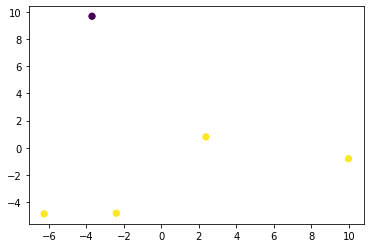

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
x = StandardScaler().fit_transform(bowMatrix)

pca = PCA(2)
x = pca.fit_transform(x)
gmm = GaussianMixture(n_components=2, covariance_type='spherical', max_iter=10).fit(x)
labels = gmm.predict(x)
#probability of each class (e.g. panic and non-panic)
panic = gmm.predict_proba(x)


plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis')
plt.show()



In [85]:
print(panic)
cvalue = panic[:, 0]
print(cvalue)

[[0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [9.99999996e-01 3.71415025e-09]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]]
[0. 0. 1. 0. 0.]
